In [1]:
import numpy as np
from scipy.linalg import null_space
from scipy.linalg import ishermitian
from scipy.linalg import issymmetric
from scipy.linalg import eigh
from scipy.linalg import norm
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.linalg import eig
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from scipy.linalg import svd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
sns.set_theme()

import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd

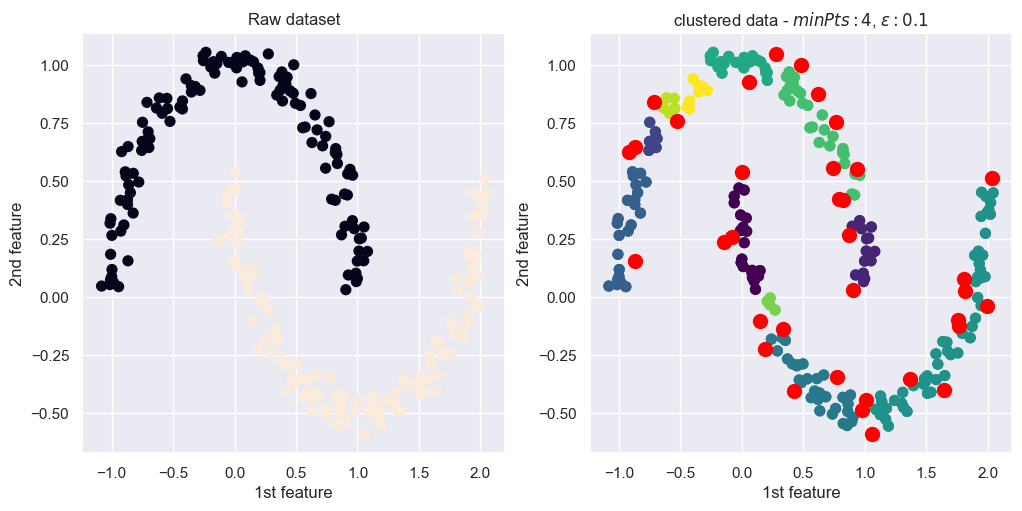

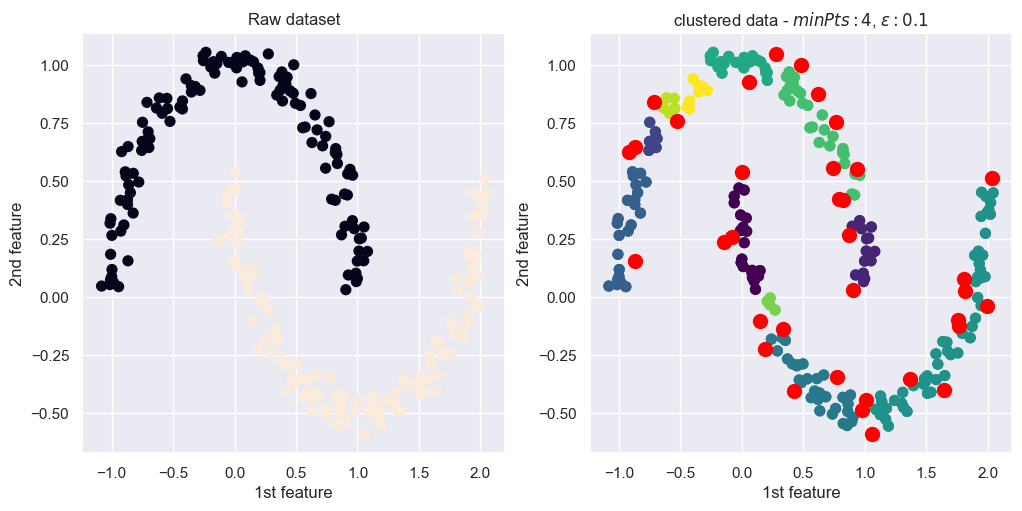

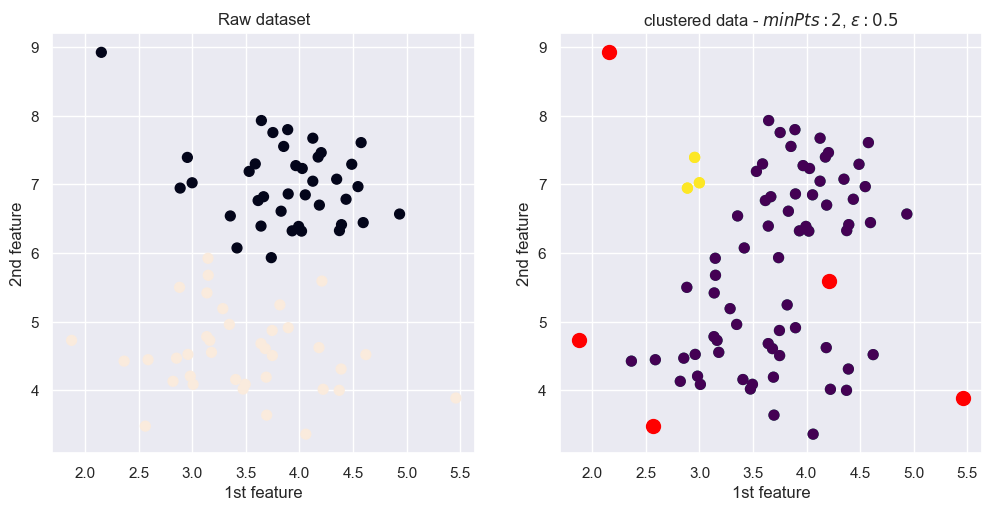

number of lambdas:  6


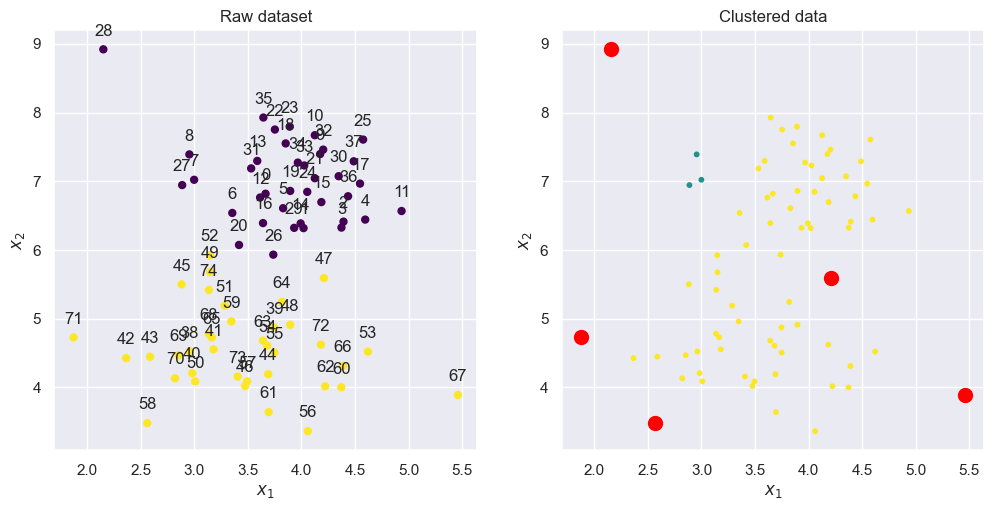

In [2]:
# running necessary functions
%run tree_plotting.ipynb
%run distance_metric.ipynb
%run density_tree.ipynb
%run DBSCAN.ipynb
%run SpectralClustering.ipynb

# Functions

In [3]:
def integrating_Fairness_Constraint(W, k, sensitive, laplacian = True):
    '''
    implementation of fair unnormalized SC with fairness constraints (algorithm 2) translated from MATLAB
    to Python
    
    github repo with original matlab code from paper: https://github.com/matthklein/fair_spectral_clustering/blob/master/Fair_SC_unnormalized.m
    
    # input: W weighted adjacency matrix (nxn), k number of clusters, sensitive encoding the sensitive attribute
    
    # output: H - eigenvectors drawn out of the subspace
    '''
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)

        # compute Laplacian from D and W (nxn)
        L = D-W
    else:
        L = W
    ######## COMPUTING L
    
    
    ######## COMPUTING F
    n = W.shape[0]
    sens_unique = np.unique(sensitive)
    h = len(sens_unique)
    sens_unique = np.reshape(sens_unique, [1,h])
    
    # sensitiveNew = sensitive.copy()  # should be npzeros
    sensitiveNEW = np.zeros(n)
    # print(n)
    
    temp = 0
    # print(len(sensitive))
    # print(len(sensitiveNEW))
    for i in range(h):
        for j in range(len(sensitive)):
            if sens_unique[0][i] == sensitive[j]:
                sensitiveNEW[j] = temp
        temp += 1
        
    # print(sensitiveNEW)
    
    # F - encodes group membership info from sensitiveNEW
    # normalize F so each 
    F = np.zeros((n, h-1)) # checkup with starting indices - F must be the issue
    for i in range(h-1):
        temp = (sensitiveNEW == i + 1)  # arrays start at 0, so need to add for boolean mask
        # print("temp: ", temp)
        F[temp, i] = 1
        groupSize = np.sum(temp)
        # print("gS \n", groupSize)
        F[:, i] = F[:, i] - (groupSize/n)  # operation that enforces balance constraint  # does it need to be i-1? 
    

    # the group membership vector sensitiveNEW - sensitivegroup/n multiplied with 1-vector
    
    
    # normalize
    F = F / np.linalg.norm(F, axis=0)
    # print(F)
    # print("normal \n", F)
    ########### COMPUTING F
    
    ########## COMPUTING Z
    
#     Z = null_space(F.T)
#     Z = Z / np.linalg.norm(Z, axis=0)  # normalized for orthonormal basis
    
    # computing with equivalency to MATLAB's null function
    U, S, V = svd(F.T)
    
    # checking dimensions and finding rank
    m, n = (F.T).shape
    rank = np.sum(S > np.finfo(float).eps * max(m, n))
    print("rank: ", rank)
    
    # extract columns of V that are singular values close to zero
    null_space = V[rank:].T
    
    # normalize columns of null_space
    null_space = null_space / np.linalg.norm(null_space, axis = 0)
    Z = null_space  # equivalency to scipy's norm function, no issue there
    
    
    ########### COMPUTING Z
    
    return Z
    

In [4]:
# https://arxiv.org/pdf/2004.05048.pdf - their ultrametric SC takes in the ultrametric, and runs the spectral clustering algorithm
# need to take first cut spectral clustering
def first_cut_spectral_clustering_EIG(W, k, laplacian = True, sim = False):
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)

        # compute Laplacian from D and W (mxn)
        L = D-W
    else:
        L = W
    ######## COMPUTING L
    
    print(L.shape)
    eigVals, eigVecs = np.linalg.eigh(L)  # can't do eigenvalue with non-square matrix
    # eigenvectors of Laplacian matrix can be obtained from the right singular vectors of the matrix obtained from the SVD (normalized L?)
    
    # matrix X from smallest eigenvectors
    if sim == True:  # similarity should ascending smallest instead of descending largest
        eigVecs = eigVecs[:, -k:] # ascending - SVD default is descending
    else:
        eigVecs = eigVecs[:, :k]  # descending
    X = eigVecs# <- works with mxn, but not compatible when plotting
    
    # normalize rows
    X = X / np.sqrt(np.sum(X**2, axis = 1, keepdims = True))
    print(X.shape)
    # Normalize the rows of the eigenvector matrix
    # row_norms = np.linalg.norm(eigVecs, axis=1)
    # eigVecs_norm = eigVecs / row_norms[:, np.newaxis]
    # X = eigVecs_norm
    
    # cluster rows via kmeans - also kmeans used in SpectralClustering.ipynb
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    labels = kmeans.labels_
    
    return labels

In [5]:
def bera_balance(clustering_labels, sensitive_attr):
    
    if len(np.unique(clustering_labels)) == 1:
        return 0
    
    d = {'G' : sensitive_attr, 'C' : clustering_labels}
    df = pd.DataFrame(data=d)
    overall_count = df.groupby('G').size().to_frame()
    overall_count.columns = ['overall']
    print(overall_count)
    
    indi_count = df.groupby(['G', 'C']).size().unstack()
    # indi_count.columns = ['c0', 'c1', 'c2']
    print("indi_count before \n", indi_count)
    num_C = np.unique(clustering_labels)
    
    indi_count.columns = [f'c{i}' for i in range(len(num_C))]
    indi_count = indi_count.fillna(0)
    print("indi_count \n", indi_count)
    result = overall_count.merge(indi_count, on='G')
    print("overall indi merged \n", result)
    
    result['r_overall'] = result['overall']/result['overall'].sum()
    # print(result)
    
    for col in indi_count.columns:
        name = 'r_' + col
        # print(name)
        result[name] = result[col]/result[col].sum()
    # print(result)
    df1 = result[['r_' + x for x in indi_count.columns]]
    # print(df1)
    balance = df1.div(result['r_overall'], axis = 0)
    balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
    print("balance \n", balance)
    print("balanec inv \n", balance_inverse)

    min_balance_dataframe = pd.DataFrame(np.minimum(balance.values, balance_inverse.values), columns=balance.columns, index=balance.index)
    # print(min_balance_dataframe)
    cluster_balances = min_balance_dataframe.min()
    print(cluster_balances)
    # min_balance = np.min(pd.concat([balance, balance_inverse]))
    min_balance = cluster_balances.min()
    
    # handle runtime warning or no?

    return min_balance

In [6]:
# imposing fairness constraint
def unnormalized_SC_With_Fairness_Constraints(W, k, sensitive, laplacian = True):
    '''
    implementation of fair unnormalized SC with fairness constraints (algorithm 2) translated from MATLAB
    to Python
    
    github repo with original matlab code from paper: https://github.com/matthklein/fair_spectral_clustering/blob/master/Fair_SC_unnormalized.m
    
    # input: W weighted adjacency matrix (nxn), k number of clusters, sensitive encoding the sensitive attribute
    
    # output: H - eigenvectors drawn out of the subspace
    '''
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)
        # print(D)

        # compute Laplacian from D and W (nxn)
        L = D-W
    else:
        L = W
    # print(L)
    ######## COMPUTING L

    
    
    ######## COMPUTING F
    n = W.shape[0]
    sens_unique = np.unique(sensitive)
    h = len(sens_unique)
    sens_unique = np.reshape(sens_unique, [1,h])
    
    # sensitiveNew = sensitive.copy()  # should be npzeros
    sensitiveNEW = np.zeros(n)
    # print(n)
    
    temp = 0
    # print(len(sensitive))
    # print(len(sensitiveNEW))
    for i in range(h):
        for j in range(len(sensitive)):
            if sens_unique[0][i] == sensitive[j]:
                sensitiveNEW[j] = temp
        temp += 1
        
    # print(sensitiveNEW)
    
    # F - encodes group membership info from sensitiveNEW
    # normalize F so each 
    F = np.zeros((n, h-1)) # checkup with starting indices - F must be the issue
    for i in range(h-1):
        temp = (sensitiveNEW == i + 1)  # arrays start at 0, so need to add for boolean mask
        # print("temp: ", temp)
        F[temp, i] = 1
        groupSize = np.sum(temp)
        # print("gS \n", groupSize)
        F[:, i] = F[:, i] - (groupSize/n)  # operation that enforces balance constraint  # does it need to be i-1? 
    

    # the group membership vector sensitiveNEW - sensitivegroup/n multiplied with 1-vector
    
    
    # normalize
    F = F / np.linalg.norm(F, axis=0)
    # print("normal \n", F)
    ########### COMPUTING F
    
    ########## COMPUTING Z
    
#     Z = null_space(F.T)
#     Z = Z / np.linalg.norm(Z, axis=0)  # normalized for orthonormal basis
    
    # computing with equivalency to MATLAB's null function
    U, S, V = svd(F.T)
    
    # checking dimensions and finding rank
    m, n = (F.T).shape
    rank = np.sum(S > np.finfo(float).eps * max(m, n))
    print("rank: ", rank)
    
    # extract columns of V that are singular values close to zero
    null_space = V[rank:].T
    
    # normalize columns of null_space
    null_space = null_space / np.linalg.norm(null_space, axis = 0)
    Z = null_space  # equivalency to scipy's norm function, no issue there
    
    
    
    ########### COMPUTING Z
    
    ########## COMPUTING eigenvectors and H
    print(Z.shape)
    print((L@Z).shape)
    print(L.shape)
    
    Z_lap = Z.T @ L @ Z
    Z_lap = (Z_lap + Z_lap.T)/2 # ensuring symmetry
    
    
    ########### COMPUTING eigenvectors and H
    
    ########## PERFORMING KMEANS

    
    # eigValues, Y = eig(Z_lap)
    # indices = eigValues.argsort()[:k]
    try:
        eigValues, Y = eigsh(Z_lap, k, which='SM', maxiter=500, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    except:
        eigValues, Y = eigsh(Z_lap, k, which='SR', maxiter=1000, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    # eigValues, Y = eig(Z_lap)
    Y = Y[:, :k]
    # print(Y)
    
    # normalize rows or no?
    # norms = np.linalg.norm(Y, axis=1)
    # Y = Y / np.reshape(norms, (-1, 1))
    
    H = Z @ Y
    # print("\n H:  \n", H)
    
    ########### PERFORMING KMEANS
    
    ########### PERFORMING KMEANS
    
    
    ######### PERFORMING DBSCAN/KMEANS
    kmeans = KMeans(n_clusters=k, random_state=0).fit(H)
    labels = kmeans.labels_
    
    # dbscan = DBSCAN(eps = eps, min_pts = minPts, cluster_type = 'standard')
    # dbscan.fit(X)
    # labels = dbscan.labels_
    # print(y.shape)
    # dbscan.plot2D(y)
    
    return H, labels
    
    ########## DBSCAN
    

    
    # return pseudo
    

In [7]:
# Compute pairwise distances

def generate_adjacency_Gaussian(data_sensitive):
    distances = squareform(pdist(data_sensitive[:, :-1]))
    # Compute similarity matrix using Gaussian kernel
    sigma = 0.5  # parameter for Gaussian kernel

    similarity = np.exp(-distances ** 2 / (2 * sigma ** 2))
    # print(similarity[0])

    # Construct weighted adjacency matrix
    n = len(data_sensitive)
    adjacency = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            w = similarity[i, j]
            adjacency[i, j] = w
            adjacency[j, i] = w
    # print(adjacency.shape)
    return adjacency
# print(adjacency[0])

In [8]:
def balance_list_over_all_k(data, sensitive, number_of_k_for_range, adjacency_matrix, 
                            min_points = 5, n_neighbors = 10, eps = 0.5, min_pts = 5):
    vanillaSC_balance = []
    vanillaDBSCAN_balance = []
    fairSC_balance = []
    fairDC_dist_balance = []

    for k in list(range(2, number_of_k_for_range)):
        dsnenns = get_nearest_neighbors(data, k, min_points)
        dsnedist = np.reshape(dsnenns['_all_dists'], -1)
        dist_dsne = dsnenns['_all_dists']
        root_, dc_dist = make_tree(data, sensitive, min_points, n_neighbors)
        
        Z = integrating_Fairness_Constraint(dist_dsne, k, sensitive, laplacian = False)
        Z_pinv = np.linalg.pinv(Z)
        Z_dist_dsne = Z_pinv.T @ (Z.T @ dist_dsne @ Z) @ Z_pinv
        
        FairDC_dist_labels = first_cut_spectral_clustering_EIG(Z_dist_dsne, k, laplacian = False, sim = False)
    
        # vanilla spectral clustering
        no_lambdas = get_lambdas(root_, eps)
        sim = get_sim_mx(dist_dsne, in_dict = False)
        SC_, vanillaSC_labels = run_spectral_clustering(root_, sim, dist_dsne, eps=eps, it = no_lambdas, min_pts = min_pts, n_clusters = 2, type_="sc")  # DEFAULT
        
        # fairSC
        fairSC_H, fairSC_labels = unnormalized_SC_With_Fairness_Constraints(adjacency_matrix, k, sensitive, laplacian = True)
        
        # vanilla DBSCAN
        dbscan = DBSCAN(eps = eps, min_pts = min_pts, cluster_type = 'corepoints')
        dbscan.fit(data)
        vanillaDBSCAN_labels = dbscan.labels_
        
        fairDC_dist_balance.append(bera_balance(FairDC_dist_labels, sensitive))
        vanillaSC_balance.append(bera_balance(vanillaSC_labels, sensitive))
        fairSC_balance.append(bera_balance(fairSC_labels, sensitive))
        vanillaDBSCAN_balance.append(bera_balance(vanillaDBSCAN_labels, sensitive))
    
    return fairDC_dist_balance, vanillaSC_balance, fairSC_balance, vanillaDBSCAN_balance
        
                                   
        

In [9]:
def labels_for_specific_k(data, sensitive, k, adjacency_matrix, 
                            min_points = 5, n_neighbors = 10, eps = 0.5, min_pts = 5):
    vanillaSC_balance = []
    vanillaDBSCAN_balance = []
    fairSC_balance = []
    fairDC_dist_balance = []
    
    dsnenns = get_nearest_neighbors(data, k, min_points)
    dsnedist = np.reshape(dsnenns['_all_dists'], -1)
    dist_dsne = dsnenns['_all_dists']
    root_, dc_dist = make_tree(data, sensitive, min_points, n_neighbors)

    Z = integrating_Fairness_Constraint(dist_dsne, k, sensitive, laplacian = False)
    Z_pinv = np.linalg.pinv(Z)
    Z_dist_dsne = Z_pinv.T @ (Z.T @ dist_dsne @ Z) @ Z_pinv

    FairDC_dist_labels = first_cut_spectral_clustering_EIG(Z_dist_dsne, k, laplacian = False, sim = False)

    # vanilla spectral clustering
    no_lambdas = get_lambdas(root_, eps)
    sim = get_sim_mx(dist_dsne, in_dict = False)
    SC_, vanillaSC_labels = run_spectral_clustering(root_, sim, dist_dsne, eps=eps, it = no_lambdas, min_pts = min_pts, n_clusters = k, type_="sc")  # DEFAULT

    # fairSC
    fairSC_H, fairSC_labels = unnormalized_SC_With_Fairness_Constraints(adjacency_matrix, k, sensitive, laplacian = True)

    # vanilla DBSCAN
    dbscan = DBSCAN(eps = eps, min_pts = min_pts, cluster_type = 'corepoints')
    dbscan.fit(data)
    vanillaDBSCAN_labels = dbscan.labels_
    
    return FairDC_dist_labels, vanillaSC_labels, fairSC_labels, vanillaDBSCAN_labels

# Synthetic DataSets

## Clean

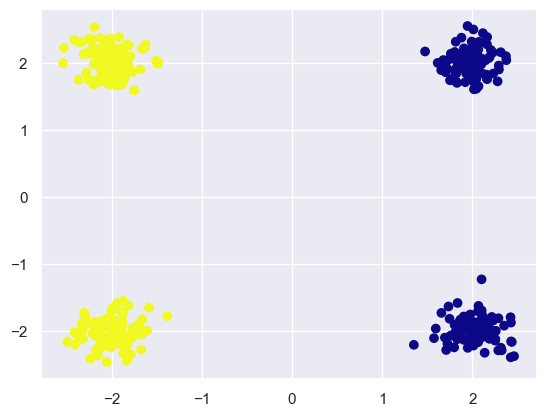

In [10]:
# generating dataset with binary sensitive attribute

# Generate random data for each cluster
n = 100
seed_value = 42
np.random.seed(seed_value)

# Generate random data for each cluster
cluster1 = np.random.normal(loc=[2, 2], scale=0.2, size=(n, 2))  # might need to make loc smaller for eps
cluster2 = np.random.normal(loc=[2, -2], scale=0.2, size=(n, 2))
cluster3 = np.random.normal(loc=[-2, -2], scale=0.2, size=(n, 2))
cluster4 = np.random.normal(loc=[-2, 2], scale=0.2, size=(n, 2))

# Create a binary-sensitive attribute
sensitive = np.concatenate((np.zeros(n*2), np.ones(n*2)))

# Combine data and shuffle
data = np.concatenate((cluster1, cluster2, cluster3, cluster4))
data_sensitive = np.concatenate((data, sensitive.reshape(-1, 1)), axis=1)

plt.scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=data_sensitive[:, 2], cmap = 'plasma')
plt.show()

In [11]:
adjacency = generate_adjacency_Gaussian(data_sensitive)

In [12]:
# SciPy default
min_points = 5
min_samples = 5
n_neighbors = 10
it = 10

In [13]:
balance_list = balance_list_over_all_k(data_sensitive, sensitive, 7, adjacency, 
                            min_points = 5, n_neighbors = 10, eps =  3, min_pts = 2)


rank:  1
(400, 400)
(400, 2)
rank:  1
(400, 399)
(400, 399)
(400, 400)
     overall
G           
0.0      200
1.0      200
indi_count before 
 C      0    1
G            
0.0  100  100
1.0  100  100
indi_count 
       c0   c1
G            
0.0  100  100
1.0  100  100
overall indi merged 
      overall   c0   c1
G                     
0.0      200  100  100
1.0      200  100  100
balance 
      r_c0  r_c1
G              
0.0   1.0   1.0
1.0   1.0   1.0
balanec inv 
      r_c0  r_c1
G              
0.0   1.0   1.0
1.0   1.0   1.0
r_c0    1.0
r_c1    1.0
dtype: float64
     overall
G           
0.0      200
1.0      200
indi_count before 
 C        0      1
G                
0.0    NaN  200.0
1.0  100.0  100.0
indi_count 
         c0     c1
G                
0.0    0.0  200.0
1.0  100.0  100.0
overall indi merged 
      overall     c0     c1
G                         
0.0      200    0.0  200.0
1.0      200  100.0  100.0
balance 
      r_c0      r_c1
G                  
0.0   0.0  1.33333

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 3)
rank:  1
(400, 399)
(400, 399)
(400, 400)
     overall
G           
0.0      200
1.0      200
indi_count before 
 C        0      1      2
G                       
0.0  100.0    NaN  100.0
1.0    NaN  100.0  100.0
indi_count 
         c0     c1     c2
G                       
0.0  100.0    0.0  100.0
1.0    0.0  100.0  100.0
overall indi merged 
      overall     c0     c1     c2
G                                
0.0      200  100.0    0.0  100.0
1.0      200    0.0  100.0  100.0
balance 
      r_c0  r_c1  r_c2
G                    
0.0   2.0   0.0   1.0
1.0   0.0   2.0   1.0
balanec inv 
      r_c0  r_c1  r_c2
G                    
0.0   0.5   inf   1.0
1.0   inf   0.5   1.0
r_c0    0.0
r_c1    0.0
r_c2    1.0
dtype: float64
     overall
G           
0.0      200
1.0      200
indi_count before 
 C        0      1
G                
0.0  200.0    NaN
1.0  100.0  100.0
indi_count 
         c0     c1
G                
0.0  200.0    0.0
1.0  100.0  100.0
overal

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 4)
rank:  1
(400, 399)
(400, 399)
(400, 400)
     overall
G           
0.0      200
1.0      200
indi_count before 
 C        0      1     2      3
G                             
0.0   28.0    NaN  72.0  100.0
1.0  100.0  100.0   NaN    NaN
indi_count 
         c0     c1    c2     c3
G                             
0.0   28.0    0.0  72.0  100.0
1.0  100.0  100.0   0.0    0.0
overall indi merged 
      overall     c0     c1    c2     c3
G                                      
0.0      200   28.0    0.0  72.0  100.0
1.0      200  100.0  100.0   0.0    0.0
balance 
        r_c0  r_c1  r_c2  r_c3
G                            
0.0  0.4375   0.0   2.0   2.0
1.0  1.5625   2.0   0.0   0.0
balanec inv 
          r_c0  r_c1  r_c2  r_c3
G                              
0.0  2.285714   inf   0.5   0.5
1.0  0.640000   0.5   inf   inf
r_c0    0.4375
r_c1    0.0000
r_c2    0.0000
r_c3    0.0000
dtype: float64
     overall
G           
0.0      200
1.0      200
indi_count befo

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 5)
rank:  1
(400, 399)
(400, 399)
(400, 400)
     overall
G           
0.0      200
1.0      200
indi_count before 
 C       0     1      2      3     4
G                                  
0.0  72.0   NaN  100.0   28.0   NaN
1.0   NaN  74.0    NaN  100.0  26.0
indi_count 
        c0    c1     c2     c3    c4
G                                  
0.0  72.0   0.0  100.0   28.0   0.0
1.0   0.0  74.0    0.0  100.0  26.0
overall indi merged 
      overall    c0    c1     c2     c3    c4
G                                           
0.0      200  72.0   0.0  100.0   28.0   0.0
1.0      200   0.0  74.0    0.0  100.0  26.0
balance 
      r_c0  r_c1  r_c2    r_c3  r_c4
G                                  
0.0   2.0   0.0   2.0  0.4375   0.0
1.0   0.0   2.0   0.0  1.5625   2.0
balanec inv 
      r_c0  r_c1  r_c2      r_c3  r_c4
G                                    
0.0   0.5   inf   0.5  2.285714   inf
1.0   inf   0.5   inf  0.640000   0.5
r_c0    0.0000
r_c1    0.0000
r_c2

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 6)
rank:  1
(400, 399)
(400, 399)
(400, 400)
     overall
G           
0.0      200
1.0      200
indi_count before 
 C       0     1     2     3     4     5
G                                      
0.0  72.0  61.0   NaN  28.0   NaN  39.0
1.0   NaN   NaN  75.0  71.0  29.0  25.0
indi_count 
        c0    c1    c2    c3    c4    c5
G                                      
0.0  72.0  61.0   0.0  28.0   0.0  39.0
1.0   0.0   0.0  75.0  71.0  29.0  25.0
overall indi merged 
      overall    c0    c1    c2    c3    c4    c5
G                                               
0.0      200  72.0  61.0   0.0  28.0   0.0  39.0
1.0      200   0.0   0.0  75.0  71.0  29.0  25.0
balance 
      r_c0  r_c1  r_c2      r_c3  r_c4     r_c5
G                                             
0.0   2.0   2.0   0.0  0.565657   0.0  1.21875
1.0   0.0   0.0   2.0  1.434343   2.0  0.78125
balanec inv 
      r_c0  r_c1  r_c2      r_c3  r_c4      r_c5
G                                             

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


In [14]:
balance_list

([1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

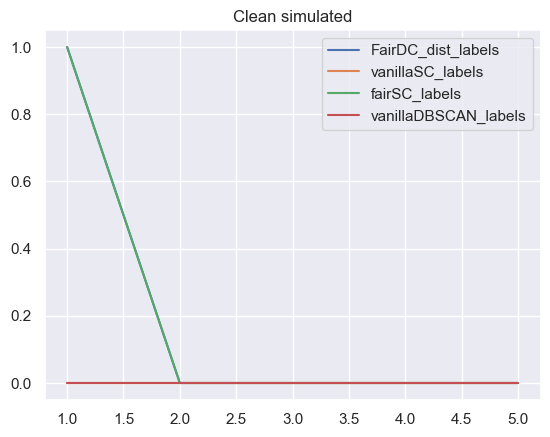

In [15]:
ks = list(range(1, 6))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, balance_list[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, balance_list[1], label = "vanillaSC_labels")
plt.plot(ks, balance_list[2], label = "fairSC_labels")
plt.plot(ks, balance_list[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Clean simulated")
plt.show()

In [16]:
labels_list = labels_for_specific_k(data_sensitive, sensitive, 2, adjacency, 
                            min_points = 5, n_neighbors = 10, eps =  3, min_pts = 2)


rank:  1
(400, 400)
(400, 2)
rank:  1
(400, 399)
(400, 399)
(400, 400)


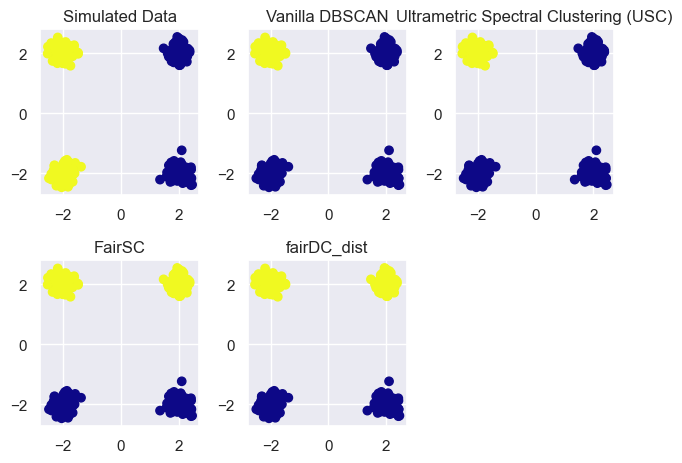

In [17]:
fig, axs = plt.subplots(2, 3)

# Plot 1
axs[0, 0].scatter(data_sensitive[:, 0], data_sensitive[:, 1], c= sensitive, cmap = "plasma")
axs[0, 0].set_title('Simulated Data')

# Plot 5
axs[1, 1].scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=labels_list[0], cmap = "plasma")
axs[1, 1].set_title('fairDC_dist')

# Plot 3
axs[0, 2].scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=labels_list[1], cmap = "plasma")
axs[0, 2].set_title('Ultrametric Spectral Clustering (USC)')  # this is actually USC

# Plot 4
axs[1, 0].scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=labels_list[2], cmap = "plasma")
axs[1, 0].set_title('FairSC')

# Plot 2
axs[0, 1].scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=labels_list[3], cmap = "plasma")
axs[0, 1].set_title('Vanilla DBSCAN')

axs[1, 2].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## Moons

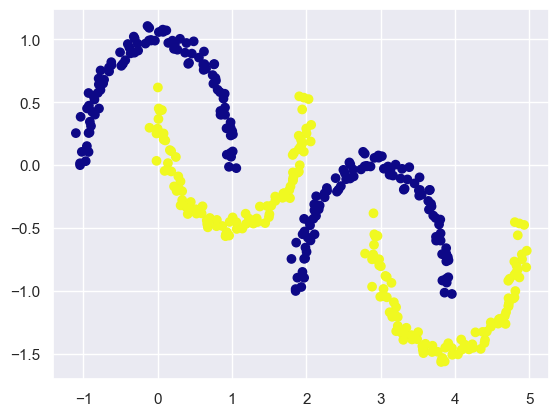

In [18]:
X1, y1 = make_moons(n_samples=200, noise=0.05, random_state=42)
# Generate the second set of moons
X2, y2 = make_moons(n_samples=200, noise=0.05, random_state=42)

# Shift the second set of moons
X2[:, 0] += 2.9
X2[:, 1] -= 1

# Combine the datasets
moons = np.vstack((X1, X2))
y_sensitive = np.hstack((y1, y2))
moons_sensitive = np.concatenate((moons, y_sensitive.reshape(-1, 1)), axis=1)


plt.scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c = moons_sensitive[:, 2], cmap = 'plasma')

In [19]:
moon_adjacency = generate_adjacency_Gaussian(moons_sensitive)

In [20]:
moons_balance_list = balance_list_over_all_k(moons, y_sensitive, 6, moon_adjacency, 
                            min_points = 5, n_neighbors = 10, eps = 3, min_pts = 5)

rank:  1
(400, 400)
(400, 2)
rank:  1
(400, 399)
(400, 399)
(400, 400)
   overall
G         
0      200
1      200
indi_count before 
 C    0    1
G          
0  100  100
1  100  100
indi_count 
     c0   c1
G          
0  100  100
1  100  100
overall indi merged 
    overall   c0   c1
G                   
0      200  100  100
1      200  100  100
balance 
    r_c0  r_c1
G            
0   1.0   1.0
1   1.0   1.0
balanec inv 
    r_c0  r_c1
G            
0   1.0   1.0
1   1.0   1.0
r_c0    1.0
r_c1    1.0
dtype: float64
   overall
G         
0      200
1      200
indi_count before 
 C      0      1
G              
0  100.0  100.0
1  200.0    NaN
indi_count 
       c0     c1
G              
0  100.0  100.0
1  200.0    0.0
overall indi merged 
    overall     c0     c1
G                       
0      200  100.0  100.0
1      200  200.0    0.0
balance 
        r_c0  r_c1
G                
0  0.666667   2.0
1  1.333333   0.0
balanec inv 
    r_c0  r_c1
G            
0  1.50   0.5
1  0.75   

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 3)
rank:  1
(400, 399)
(400, 399)
(400, 400)
   overall
G         
0      200
1      200
indi_count before 
 C      0      1      2
G                     
0  100.0    NaN  100.0
1    NaN  100.0  100.0
indi_count 
       c0     c1     c2
G                     
0  100.0    0.0  100.0
1    0.0  100.0  100.0
overall indi merged 
    overall     c0     c1     c2
G                              
0      200  100.0    0.0  100.0
1      200    0.0  100.0  100.0
balance 
    r_c0  r_c1  r_c2
G                  
0   2.0   0.0   1.0
1   0.0   2.0   1.0
balanec inv 
    r_c0  r_c1  r_c2
G                  
0   0.5   inf   1.0
1   inf   0.5   1.0
r_c0    0.0
r_c1    0.0
r_c2    1.0
dtype: float64
   overall
G         
0      200
1      200
indi_count before 
 C      0      1
G              
0  100.0  100.0
1  200.0    NaN
indi_count 
       c0     c1
G              
0  100.0  100.0
1  200.0    0.0
overall indi merged 
    overall     c0     c1
G                       
0     

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 4)
rank:  1
(400, 399)
(400, 399)
(400, 400)
   overall
G         
0      200
1      200
indi_count before 
 C      0      1      2     3
G                           
0  100.0   44.0    NaN  56.0
1    NaN  100.0  100.0   NaN
indi_count 
       c0     c1     c2    c3
G                           
0  100.0   44.0    0.0  56.0
1    0.0  100.0  100.0   0.0
overall indi merged 
    overall     c0     c1     c2    c3
G                                    
0      200  100.0   44.0    0.0  56.0
1      200    0.0  100.0  100.0   0.0
balance 
    r_c0      r_c1  r_c2  r_c3
G                            
0   2.0  0.611111   0.0   2.0
1   0.0  1.388889   2.0   0.0
balanec inv 
    r_c0      r_c1  r_c2  r_c3
G                            
0   0.5  1.636364   inf   0.5
1   inf  0.720000   0.5   inf
r_c0    0.000000
r_c1    0.611111
r_c2    0.000000
r_c3    0.000000
dtype: float64
   overall
G         
0      200
1      200
indi_count before 
 C      0      1
G              
0  

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


rank:  1
(400, 400)
(400, 5)
rank:  1
(400, 399)
(400, 399)
(400, 400)
   overall
G         
0      200
1      200
indi_count before 
 C     0     1     2      3     4
G                               
0   NaN  54.0   NaN  100.0  46.0
1  90.0   NaN  90.0   20.0   NaN
indi_count 
      c0    c1    c2     c3    c4
G                               
0   0.0  54.0   0.0  100.0  46.0
1  90.0   0.0  90.0   20.0   0.0
overall indi merged 
    overall    c0    c1    c2     c3    c4
G                                        
0      200   0.0  54.0   0.0  100.0  46.0
1      200  90.0   0.0  90.0   20.0   0.0
balance 
    r_c0  r_c1  r_c2      r_c3  r_c4
G                                  
0   0.0   2.0   0.0  1.666667   2.0
1   2.0   0.0   2.0  0.333333   0.0
balanec inv 
    r_c0  r_c1  r_c2  r_c3  r_c4
G                              
0   inf   0.5   inf   0.6   0.5
1   0.5   inf   0.5   3.0   inf
r_c0    0.000000
r_c1    0.000000
r_c2    0.000000
r_c3    0.333333
r_c4    0.000000
dtype: float64
  

C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)
C:\Users\annek\AppData\Local\Temp\ipykernel_29640\2014953683.py:34: RuntimeWarning: divide by zero encountered in reciprocal
  balance_inverse = pd.DataFrame(np.reciprocal(balance.values), columns=balance.columns, index=balance.index)


In [21]:
# starts at 2 clusters
moons_balance_list

([1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.0, 0.6016260162601627, 0.0, 0.0],
 [0, 0, 0, 0])

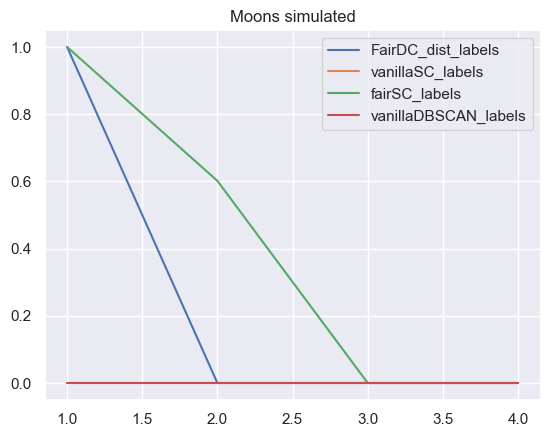

In [22]:
ks = list(range(1, 5))
# vanilla refers to pre-fairness algorithm
plt.plot(ks, moons_balance_list[0], label = "FairDC_dist_labels")  # dc_dist
plt.plot(ks, moons_balance_list[1], label = "vanillaSC_labels")
plt.plot(ks, moons_balance_list[2], label = "fairSC_labels")
plt.plot(ks, moons_balance_list[3], label = "vanillaDBSCAN_labels")  # not fluctuating with any of the parameters
plt.legend()
plt.title("Moons simulated")
plt.show()

In [23]:
labels_list = labels_for_specific_k(moons, y_sensitive, 2, moon_adjacency, 
                            min_points = 5, n_neighbors = 10, eps = 1, min_pts = 5)

rank:  1
(400, 400)
(400, 2)
rank:  1
(400, 399)
(400, 399)
(400, 400)


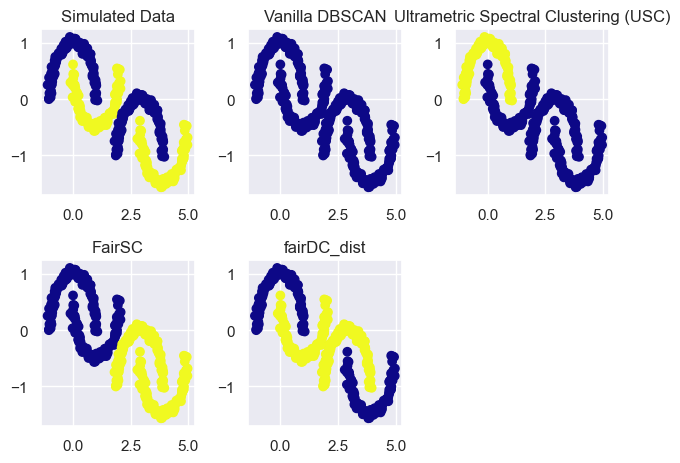

In [24]:
fig, axs = plt.subplots(2, 3)

# Plot 1
axs[0, 0].scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c= moons_sensitive[:, 2], cmap = "plasma")
axs[0, 0].set_title('Simulated Data')

# Plot 5
axs[1, 1].scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c=labels_list[0], cmap = "plasma")
axs[1, 1].set_title('fairDC_dist')

# Plot 3
axs[0, 2].scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c=labels_list[1], cmap = "plasma")
axs[0, 2].set_title('Ultrametric Spectral Clustering (USC)')  # this is actually USC

# Plot 4
axs[1, 0].scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c=labels_list[2], cmap = "plasma")
axs[1, 0].set_title('FairSC')

# Plot 2
axs[0, 1].scatter(moons_sensitive[:, 0], moons_sensitive[:, 1], c=labels_list[3], cmap = "plasma")
axs[0, 1].set_title('Vanilla DBSCAN')

axs[1, 2].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

# here we see a situation in which the fairDC_dist has a balance of 1, however the applicability and 
# quality of the clustering are obviously poor. How can this be explained?

In [ ]:
# unfriendly could be the circle dataset with one circle inside of another?

In [ ]:
# a realistic unfriendly situation in the synthetic datasets break it